# Multiple linear regression model
### Building our trading model of SPY, base on the historical data of different stock markets

In [1]:
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

https://es.investing.com/ 

In [3]:
# import all stock market data into DataFrame
MSCI = pd.read_csv('C:/Users/Usuario/Desktop/proyectos/Analisis_Financiero_1/Datasets/MSCI Brazil Capped (EWZ).csv', index_col=0, parse_dates=True) # ETF de empresas grandes y medianas Brazil           
SPDR = pd.read_csv('C:/Users/Usuario/Desktop/proyectos/Analisis_Financiero_1/Datasets/Financial Select Sector SPDR (XLF).csv', index_col=0, parse_dates=True) #  Índice subyacente: S&P 500 Financials Index
EZU = pd.read_csv('C:/Users/Usuario/Desktop/proyectos/Analisis_Financiero_1/Datasets/MSCI Eurozone (EZU).csv', index_col=0, parse_dates=True)   #  ETF grandes y medianas de Europa
EWJ = pd.read_csv('C:/Users/Usuario/Desktop/proyectos/Analisis_Financiero_1/Datasets/MSCI Japan (EWJ).csv', index_col=0, parse_dates=True)  # ETF grandes y medianas de Japón
QQQ = pd.read_csv('C:/Users/Usuario/Desktop/proyectos/Analisis_Financiero_1/Datasets/Invesco QQQ Trust.csv', index_col=0, parse_dates=True) # ETF índice Nasdaq-100
sp500 = pd.read_csv('C:/Users/Usuario/Desktop/proyectos/Analisis_Financiero_1/Datasets/IND-S&P-500-SPX.csv', index_col=0, parse_dates=True)  # IND-S&P-500-SPX   OK
dji = pd.read_csv('C:/Users/Usuario/Desktop/proyectos/Analisis_Financiero_1/Datasets/DowJones.csv', index_col=0, parse_dates=True) # Dow Jones Industrial Average (DJI) OK
nasdaq = pd.read_csv('C:/Users/Usuario/Desktop/proyectos/Analisis_Financiero_1/Datasets/Nasdaq.csv', index_col=0, parse_dates=True)  # NASDAQ Composite (IXIC)   OK
spy = pd.read_csv('C:/Users/Usuario/Desktop/proyectos/Analisis_Financiero_1/Datasets/ETF-SPDR-S&P500.csv', index_col=0, parse_dates=True) # ETF-SPDR-S&P500 OK

                                 Hago un analisis preliminar de la extructura y verifico variables

In [4]:
#Se verifica y el index fecha tiene formato objeto                  
dataframes = [MSCI, SPDR, EZU, EWJ, QQQ, sp500, dji, nasdaq, spy]
for i in dataframes:
    print(i.index.dtype,"-",i.index.name) 

object - Fecha
object - Fecha
object - Fecha
object - Fecha
object - Fecha
object - Fecha
object - Fecha
object - Fecha
object - Fecha


In [5]:
# Se transforma la columna index en datatime                         # atributo de un indice
dataframes = [MSCI, SPDR, EZU, EWJ, QQQ, sp500, dji, nasdaq, spy]
for i in dataframes:
    i.index = pd.to_datetime(i.index, format="%d.%m.%Y")
    print(i.index.dtype,"-",i.index.name)  

datetime64[ns] - Fecha
datetime64[ns] - Fecha
datetime64[ns] - Fecha
datetime64[ns] - Fecha
datetime64[ns] - Fecha
datetime64[ns] - Fecha
datetime64[ns] - Fecha
datetime64[ns] - Fecha
datetime64[ns] - Fecha


In [6]:
#Corroboro columna "0" como indice del data   # aord nikkei hsi daxi cac40 sp500 dji nasdaq spy
SPDR.head()

,Último,Apertura,Máximo,Mínimo,Vol.,% var.
Fecha,,,,,,
2025-03-12,"47,68","48,12","48,19","47,22","60,70M","0,15%"
2025-03-11,"47,61","47,95","48,08","47,28","72,97M","-0,85%"
2025-03-10,"48,02","48,29","48,60","47,46","78,22M","-2,24%"
2025-03-07,"49,12","49,20","49,33","48,25","87,35M","-0,53%"
2025-03-06,"49,38","49,62","49,96","49,06","55,48M","-1,65%"


In [7]:
# Conversión de datos criticos en floats

def convert_to_float(x):                                    # convert_to_float > y : output    x: input
    if isinstance(x, str):                                  # isinstance(objeto, tipo) > Si el resultado es TRUE > return
        x = x.replace('.', '').replace(',', '.')            # Redefino a X: Corrige formato europeo
    return float(x)

# Lista de los DataFrames que quieres procesar
dataframes = [MSCI, SPDR, EZU, EWJ, QQQ, sp500, dji, nasdaq, spy]

# Lista de las columnas que quieres transformar
columnas = ['Último', 'Apertura']

# Iterar sobre los DataFrames y aplicar la función a las columnas seleccionadas
for df in dataframes:
    df[columnas] = df[columnas].applymap(convert_to_float)


In [8]:
#Se verifica que los datos correspondientes se conviertan en floats
dataframes = [MSCI, SPDR, EZU, EWJ, QQQ, sp500, dji, nasdaq, spy]
for x in dataframes:
    print(x.dtypes)
    print("-" * 10) 

Último      float64
Apertura    float64
Máximo       object
Mínimo       object
Vol.         object
% var.       object
dtype: object
----------
Último      float64
Apertura    float64
Máximo       object
Mínimo       object
Vol.         object
% var.       object
dtype: object
----------
Último      float64
Apertura    float64
Máximo       object
Mínimo       object
Vol.         object
% var.       object
dtype: object
----------
Último      float64
Apertura    float64
Máximo       object
Mínimo       object
Vol.         object
% var.       object
dtype: object
----------
Último      float64
Apertura    float64
Máximo       object
Mínimo       object
Vol.         object
% var.       object
dtype: object
----------
Último      float64
Apertura    float64
Máximo       object
Mínimo       object
Vol.         object
% var.       object
dtype: object
----------
Último      float64
Apertura    float64
Máximo       object
Mínimo       object
Vol.         object
% var.       object
dtype: obj

## Step 1: Data Munging

In [9]:
# Due to the timezone issues, we extract and calculate appropriate stock market data for analysis
# Indicepanel is the DataFrame of our trading model [MSCI, SPDR, EZU, EWJ, QQQ, sp500, dji, nasdaq, spy]
indicepanel=pd.DataFrame(index=spy.index)

#Variable DEPENDIENTE  - (ETF del S&P 500)                                                           t+1 - t
indicepanel['spy']=spy['Apertura'].shift(-1)-spy['Apertura']     # cómo cambia la apertura de un día al siguiente Fecha de mañana vs Fecha hoy ( primer fila)
indicepanel['spy_lag1']=indicepanel['spy'].shift(1)     # desplaza todas la filas hacia abajo porque le diferencia corresponde al día posterior

#Variables independientes
indicepanel['MSCI']=MSCI['Apertura']-MSCI['Apertura'].shift(1)   # Fecha de hoy vs mañana   t -  t-1
indicepanel['SPDR']=SPDR['Apertura']-SPDR['Apertura'].shift(1)
indicepanel['EZU']=EZU['Último']-EZU['Apertura'].shift(1)
indicepanel['EWJ']=EWJ['Último']-EWJ['Apertura'].shift(1)
indicepanel['QQQ']=QQQ['Último']-QQQ['Apertura'].shift(1)
indicepanel['sp500']=sp500["Apertura"]-sp500['Apertura'].shift(1)   
indicepanel['dji']=dji['Apertura']-dji['Apertura'].shift(1)
indicepanel['nasdaq']=nasdaq['Apertura']-nasdaq['Apertura'].shift(1)  

indicepanel['Price']=spy['Apertura']   # precio de apertura de S&P 500  como precio referencia.

In [10]:
indicepanel.head()

,spy,spy_lag1,MSCI,SPDR,EZU,EWJ,QQQ,sp500,dji,nasdaq,Price
Fecha,,,,,,,,,,,
2025-03-12,-2.77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,562.17
2025-03-11,8.19,-2.77,-0.05,-0.17,-0.29,-1.01,-7.56,-21.19,260.45,-268.32,559.40
2025-03-10,3.31,8.19,0.24,0.34,-0.35,0.20,0.38,101.72,669.70,397.23,567.59
2025-03-07,4.58,3.31,0.04,0.91,1.03,0.99,8.34,20.64,-4.58,189.53,570.90
2025-03-06,1.21,4.58,-0.03,0.42,0.00,-0.16,1.04,59.86,345.42,174.68,575.48


In [11]:
#Ordeno los datos de forma ascendente
indicepanel2 = indicepanel.sort_index(ascending=True)
indicepanel2.head()

,spy,spy_lag1,MSCI,SPDR,EZU,EWJ,QQQ,sp500,dji,nasdaq,Price
Fecha,,,,,,,,,,,
2021-01-04,NaN,7.21,1.90,0.52,0.07,-0.24,1.02,66.6,423.22,292.87,375.31
2021-01-05,7.21,-1.61,-0.62,-0.70,-0.23,0.07,4.86,-14.2,-158.53,-0.50,368.10
2021-01-06,-1.61,-6.39,-0.61,-1.18,-0.04,0.31,-2.74,-52.5,-538.40,-201.19,369.71
2021-01-07,-6.39,-4.49,-0.74,-0.14,-0.17,-1.10,-2.36,-50.4,-168.40,-292.88,376.10
2021-01-08,-4.49,2.74,0.94,0.47,0.98,0.88,3.05,12.0,54.21,111.44,380.59


In [12]:
# Lets check whether do we have NaN values in indicepanel
indicepanel2.isnull().sum()

spy         1
spy_lag1    1
MSCI        1
SPDR        1
EZU         1
EWJ         1
QQQ         6
sp500       6
dji         6
nasdaq      6
Price       0
dtype: int64

In [18]:
# We can use method 'fillna()' from dataframe to forward filling the Nan values 
#'ffill': Rellenar los NaN con el valor anterior en la misma columna (relleno hacia adelante)  vs 'bfill'
indicepanel2 = indicepanel2.fillna(method='ffill')

## Then we can drop the reminding Nan values # Se elimna la fila entera
indicepanel2 = indicepanel2.dropna()   

In [19]:
# Lets check whether do we have Nan values in indicepanel now
indicepanel2.isnull().sum()

spy         0
spy_lag1    0
MSCI        0
SPDR        0
EZU         0
EWJ         0
QQQ         0
sp500       0
dji         0
nasdaq      0
Price       0
dtype: int64

In [21]:
# save this indicepanel2 for part 4.5
path_save = 'C:/Users/Usuario/Desktop/proyectos/Analisis_Financiero_1/Datasets/indicepanel2.csv'
indicepanel2.to_csv(path_save)

In [22]:
print(indicepanel2.describe())

               spy     spy_lag1         MSCI         SPDR          EZU  \
count  1056.000000  1056.000000  1056.000000  1056.000000  1056.000000   
mean     -0.176951    -0.186402     0.010748    -0.018201     0.006998   
std       4.574544     4.569574     0.570325     0.442431     0.435859   
min     -19.350000   -19.350000    -2.760000    -2.720000    -2.110000   
25%      -2.870000    -2.870000    -0.330000    -0.270000    -0.240000   
50%      -0.450000    -0.460000     0.015000    -0.050000    -0.020000   
75%       2.022500     2.002500     0.310000     0.200000     0.230000   
max      24.110000    24.110000     2.560000     2.240000     2.290000   

               EWJ          QQQ        sp500          dji       nasdaq  \
count  1056.000000  1056.000000  1056.000000  1056.000000  1056.000000   
mean      0.018258    -0.147784    -1.946146   -10.961278    -5.239441   
std       0.569145     2.946659    43.260646   290.017197   198.844713   
min      -2.560000   -12.690000  -170

## Step 2: Data Spliting

In [23]:
indicepanel2.head()

,spy,spy_lag1,MSCI,SPDR,EZU,EWJ,QQQ,sp500,dji,nasdaq,Price
Fecha,,,,,,,,,,,
2021-01-05,7.21,-1.61,-0.62,-0.70,-0.23,0.07,4.86,-14.2,-158.53,-0.50,368.10
2021-01-06,-1.61,-6.39,-0.61,-1.18,-0.04,0.31,-2.74,-52.5,-538.40,-201.19,369.71
2021-01-07,-6.39,-4.49,-0.74,-0.14,-0.17,-1.10,-2.36,-50.4,-168.40,-292.88,376.10
2021-01-08,-4.49,2.74,0.94,0.47,0.98,0.88,3.05,12.0,54.21,111.44,380.59
2021-01-11,2.74,-1.04,0.11,-0.58,0.06,0.07,-0.04,1.5,0.36,-13.28,377.85


In [24]:
indicepanel2.tail()

,spy,spy_lag1,MSCI,SPDR,EZU,EWJ,QQQ,sp500,dji,nasdaq,Price
Fecha,,,,,,,,,,,
2025-03-06,1.21,4.58,-0.03,0.42,0.00,-0.16,1.04,59.86,345.42,174.68,575.48
2025-03-07,4.58,3.31,0.04,0.91,1.03,0.99,8.34,20.64,-4.58,189.53,570.90
2025-03-10,3.31,8.19,0.24,0.34,-0.35,0.20,0.38,101.72,669.70,397.23,567.59
2025-03-11,8.19,-2.77,-0.05,-0.17,-0.29,-1.01,-7.56,-21.19,260.45,-268.32,559.40
2025-03-12,-2.77,-2.77,-0.05,-0.17,-0.29,-1.01,-7.56,-21.19,260.45,-268.32,562.17


In [25]:
print(indicepanel.shape)

(1057, 11)


In [26]:
# split the data into (1)train set and (2)test set
Train = indicepanel2.iloc[0:500,:]
Test = indicepanel2.iloc[500:1000,:]

print(Train.shape, Test.shape)


(500, 11) (500, 11)


## Step 3: Explore the train data set

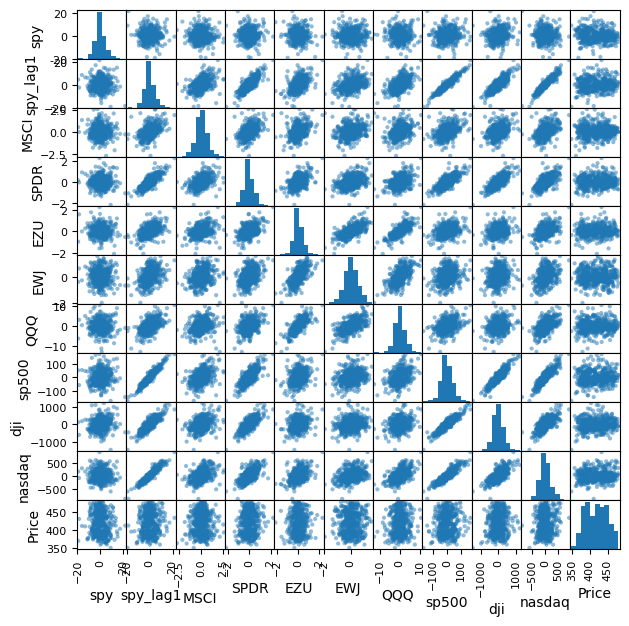

In [27]:
# Generate scatter matrix among all stock markets (and the price of SPY) to observe the association

from pandas.plotting import scatter_matrix
#from pandas.tools.plotting import scatter_matrix
sm = scatter_matrix(Train, figsize=(7, 7))


## Step 4: Check the correlation of each index between spy

In [28]:
# Find the indice with largest correlation
corr_array = Train.iloc[:, :-1].corr()['spy']
print(corr_array)

spy         1.000000
spy_lag1   -0.019808
MSCI       -0.031861
SPDR        0.002155
EZU        -0.045418
EWJ        -0.013580
QQQ        -0.023703
sp500       0.094086
dji         0.174822
nasdaq     -0.052805
Name: spy, dtype: float64


Se analiza la **Prueba de hipótesis t (Prob (F-statistic) :**

$H_0 : \beta_1, \beta_2, ..., \beta_n$ = 0         -             *No son significativamente diferentes de "0"*

$H_a$ : al menos una de ellas es diferentes de "0"          -    *Una de ellas es positiva*

Por lo que, si el estadistico es menor a 0.05 rechazamos hipotesis nula

En este caso Prob (F-statistic): 4.45e-25 es mucho menor que 0.05, por lo que rechazamos la hipótesis nula. Esto significa que al menos uno de los predictores en el modelo es significativamente diferente de cero y contribuye a explicar la variable dependiente (Y)

-----------------

Tambien se analiza la significancia de individual de cada predictor **P>|t|**

$H_0: \beta_n = 0 $

$H_a: \beta_n \neq 0 $

Los predictores dji, MSCI, SPDR, EZU, EWJ: No son significativos, ya que sus valores de P>|t| son mayores que 0.05.


In [29]:
formula = 'spy~spy_lag1+sp500+nasdaq+dji+MSCI+SPDR+EZU+EWJ+QQQ' #[MSCI, SPDR, EZU, EWJ, QQQ, sp500, dji, nasdaq, spy]
lm = smf.ols(formula=formula, data=Train).fit()   
lm.summary()  

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    spy   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     17.41
Date:                Tue, 01 Apr 2025   Prob (F-statistic):           4.45e-25
Time:                        13:29:00   Log-Likelihood:                -1441.4
No. Observations:                 500   AIC:                             2903.
Df Residuals:                     490   BIC:                             2945.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0161      0.197      0.082      0.935      -0.372       0.404
spy_lag1      -1.7490      0.254     -6.890      0.000      -2.248      -1.250
sp500          0.2116      0.029      7.308      0.000       0.155       0.269
nasdaq        -0.0106      0.004     -2.585      0.010      -0.019      -0.003
dji            0.0009      0.002      0.406      0.685      -0.004       0.005
MSCI           0.0945      0.328      0.288      0.773      -0.550       0.739
SPDR          -0.0334      0.863     -0.039      0.969      -1.729       1.662
EZU            0.8317      0.727      1.145      0.253      -0.596       2.259
EWJ            0.6665      0.504      1.321      0.187      -0.325       1.658
QQQ            0.4636      0.122      3.803      0.000       0.224       0.703
==============================================================================
Omnibus:                       19.131   Durbin-Watson:                   2.064
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.946
Skew:                           0.257   Prob(JB):                     7.01e-08
Kurtosis:                       4.148   Cond. No.                     1.64e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.64e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Multicolinealidad**

In [30]:
Train.iloc[:,:-1].corr()

,spy,spy_lag1,MSCI,SPDR,EZU,EWJ,QQQ,sp500,dji,nasdaq
spy,1.000000,-0.019808,-0.031861,0.002155,-0.045418,-0.013580,-0.023703,0.094086,0.174822,-0.052805
spy_lag1,-0.019808,1.000000,0.439359,0.808780,0.480143,0.383364,0.532329,0.958737,0.845219,0.940879
MSCI,-0.031861,0.439359,1.000000,0.435525,0.348459,0.238205,0.262518,0.388792,0.340832,0.393689
SPDR,0.002155,0.808780,0.435525,1.000000,0.464855,0.382719,0.379495,0.758056,0.764844,0.649082
EZU,-0.045418,0.480143,0.348459,0.464855,1.000000,0.653980,0.751561,0.329755,0.236435,0.444208
EWJ,-0.013580,0.383364,0.238205,0.382719,0.653980,1.000000,0.608217,0.265961,0.190833,0.370661
QQQ,-0.023703,0.532329,0.262518,0.379495,0.751561,0.608217,1.000000,0.388440,0.257239,0.547303
sp500,0.094086,0.958737,0.388792,0.758056,0.329755,0.265961,0.388440,1.000000,0.919149,0.906695
dji,0.174822,0.845219,0.340832,0.764844,0.236435,0.190833,0.257239,0.919149,1.000000,0.716059
nasdaq,-0.052805,0.940879,0.393689,0.649082,0.444208,0.370661,0.547303,0.906695,0.716059,1.000000


## Step 5: Make prediction

In [31]:
# predicciones propiamentedichas
Train['PredictedY'] = lm.predict(Train)  # Usando datos entrenados   
Test['PredictedY'] = lm.predict(Test)    # NO Usando datos entrenados   

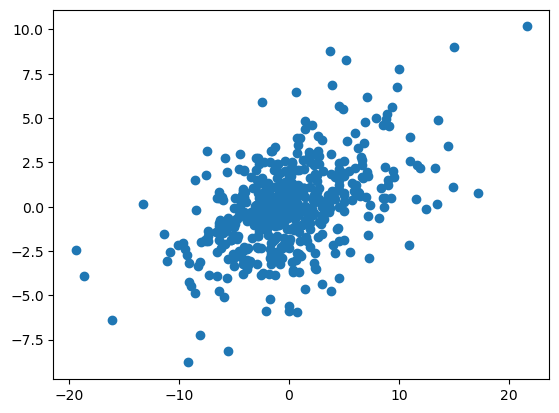

In [32]:
#Compara valores reales y predichos en el conjunto de entrenamiento
plt.scatter(Train['spy'], Train['PredictedY'])

## Step 6: Model evaluation - Statistical standard

We can measure the performance of our model using some statistical metrics: 

$RMSE-Adjusted$: Mide la raíz del error cuadrático medio, es decir, cuánto se desvían en promedio las predicciones del modelo de los valores reales.

$R^2$ : Mide cuánto de la variabilidad de Y explicada por el modelo, ajustado por el número de predictores.

In [33]:
def adjustedMetric(data, model, model_k, yname):
    data['yhat'] = model.predict(data)  # Predicciones del modelo
    SST = ((data[yname] - data[yname].mean())**2).sum()  # Suma total de cuadrados
    SSR = ((data['yhat'] - data[yname].mean())**2).sum()  # Suma de cuadrados de la regresión
    SSE = ((data[yname] - data['yhat'])**2).sum()  # Suma de cuadrados de los errores
    r2 = SSR/SST  # Coeficiente de determinación R²
    adjustR2 = 1 - (1-r2)*(data.shape[0] - 1)/(data.shape[0] -model_k -1)  # R² ajustado
    RMSE = (SSE/(data.shape[0] -model_k -1))**0.5  # RMSE
    return adjustR2, RMSE

In [34]:
# Evaluar en Train (ajuste del modelo)
adjustR2_train, RMSE_train = adjustedMetric(Train, lm, 9, 'spy')
print("Resultados para Train:")
print("adjustR2:", adjustR2_train)
print("RMSE:", RMSE_train)

Resultados para Train:
adjustR2: 0.22841115840870896
RMSE: 4.366491991913915


Comparar el rendimiento del modelo en Train y Test

In [35]:
#Calculo para ambos conjuntos de datos 
def assessTable(test, train, model, model_k, yname):
    
    r2test, RMSEtest = adjustedMetric(test, model, model_k, yname)  # calcula R2 y RMSE con datos de prueba    
    r2train, RMSEtrain = adjustedMetric(train, model, model_k, yname) # calcula R2 y RMSE con datos de entrenamiento
    
    assessment = pd.DataFrame(index=['R2', 'RMSE'], columns=['Train', 'Test'])   # crea dataframe
    assessment['Train'] = [r2train, RMSEtrain]
    assessment['Test'] = [r2test, RMSEtest]
    return assessment

In [36]:
# Get the assement table fo our model
assessTable(Test, Train, lm, 9, 'spy')  # input de datos

,Train,Test
R2,0.228411,0.216346
RMSE,4.366492,3.631055


**El rendimiento general del modelo es bajo (R2 bajo y RMSE alto), lo que sugiere que el modelo no es muy útil para predecir Y.** 

**Sin embargo, no está sobreajustado, lo que es una buena señal**